In [1]:
import warnings
warnings.filterwarnings('ignore')

# 1. Get data ready

## 1.1. Create a dummy dataset for binary classification

In [2]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, noise=0.03, random_state=42)

In [3]:
X.shape, type(X), X.dtype, y.shape, type(y), y.dtype

((1000, 2),
 numpy.ndarray,
 dtype('float64'),
 (1000,),
 numpy.ndarray,
 dtype('int64'))

In [4]:
import pandas as pd

circles = pd.DataFrame({"X0": X[:, 0], "X1": X[:, 1], "label": y})
circles.head()

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


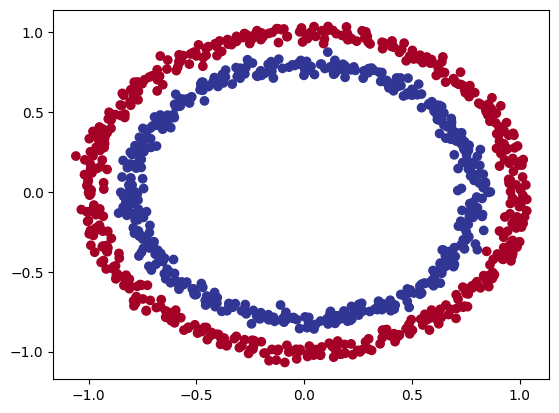

In [5]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

## 1.2. Turn data into tensors

In [6]:
import torch

torch.__version__

'2.1.0'

In [7]:
# `torch.tensor()`: copy the original data, not sharing memory, and can work with a broader range of data types
# `torch.from_numpy()`: tensor shares memory with a numpy array, thus saving memory

X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

X.shape, type(X), X.dtype, y.shape, type(y), y.dtype

(torch.Size([1000, 2]),
 torch.Tensor,
 torch.float32,
 torch.Size([1000]),
 torch.Tensor,
 torch.float32)

## 1.3. Make train/test splits

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [9]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

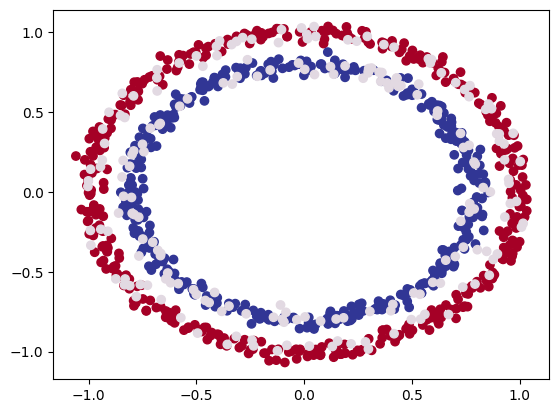

In [10]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdYlBu)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.twilight)
plt.show();

# 2. Build a model

## 2.1. Setup device agnostic code

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## 2.2. Construct a model

### 2.2.1. by subclassing `nn.module`

In [12]:
from torch import nn

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # define layers capable of handling the input data
    self.layer_1 = nn.Linear(in_features=2, out_features=8)
    self.layer_2 = nn.Linear(in_features=8, out_features=1)

    # forward propagation function
    def forward(self, x):
      return self.layer_2(self.layer_1(x))
    
model0 = CircleModelV0().to(device)
model0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)

In [13]:
model0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.3500, -0.5155],
                      [-0.0908,  0.2291],
                      [ 0.6043, -0.6255],
                      [-0.3162,  0.3454],
                      [-0.6891,  0.5917],
                      [-0.2183, -0.2892],
                      [-0.0804, -0.2784],
                      [ 0.5615, -0.3770]])),
             ('layer_1.bias',
              tensor([ 0.5713,  0.5844, -0.2561, -0.5896,  0.5434,  0.1828,  0.3366,  0.2010])),
             ('layer_2.weight',
              tensor([[-0.1355, -0.1281, -0.2518, -0.0561, -0.1676, -0.2302, -0.1926, -0.0497]])),
             ('layer_2.bias', tensor([-0.2505]))])

### 2.2.2. by using `nn.Sequential`

In [14]:
model0 = nn.Sequential(
  nn.Linear(in_features=2, out_features=8),
  nn.Linear(in_features=8, out_features=1)
).to(device)

model0

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)

In [15]:
model0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.1443,  0.3024],
                      [-0.6960,  0.6699],
                      [-0.6737,  0.3771],
                      [-0.4730, -0.3870],
                      [-0.2460,  0.3605],
                      [ 0.3678, -0.6942],
                      [-0.6493, -0.1591],
                      [ 0.5039,  0.4132]])),
             ('0.bias',
              tensor([-0.0825, -0.4653, -0.3855, -0.0304,  0.3388, -0.0755, -0.2989,  0.5294])),
             ('1.weight',
              tensor([[-0.0639, -0.0580,  0.0605, -0.1364,  0.3070,  0.1939,  0.1825, -0.1642]])),
             ('1.bias', tensor([0.0149]))])

### 2.2.3. making test predictions

In [16]:
# `untrained_logits`: the output of the model before any additional handling
with torch.inference_mode():
  untrained_logits = model0(X_test.to(device))
untrained_logits.shape, untrained_logits[:5].squeeze()

(torch.Size([200, 1]), tensor([-0.0383, -0.1258,  0.1142, -0.0812, -0.0078]))

In [17]:
# `untrained_preds_probs`: the probability of the logits after applying the sigmoid function
untrained_preds_probs = torch.sigmoid(untrained_logits)
untrained_preds_probs[:5].squeeze()

tensor([0.4904, 0.4686, 0.5285, 0.4797, 0.4980])

In [18]:
# `untrained_preds`: the predictions after applying the threshold of 0.5
untrained_preds = torch.round(untrained_preds_probs)

y_test[:5], untrained_preds[:5].squeeze()

(tensor([1., 0., 1., 0., 1.]), tensor([0., 0., 1., 0., 0.]))

## 2.3. Pick a loss function and optimizer

* `nn.BCEWithLogitsLoss` combines a built-in sigmoid activation function and binary cross entropy loss in one class.

* `optim.Adam` implements the Adam algorithm, which is a gradient-based optimization algorithm based on adaptive estimates of lower-order moments.

In [19]:
loss_fn = nn.BCEWithLogitsLoss()
loss_fn

BCEWithLogitsLoss()

In [20]:
optim = torch.optim.SGD(params=model0.parameters(), lr=0.1)
optim

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

## 2.4. Create evaluation metrics

In [21]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(y_true, y_pred):
  f1 = f1_score(y_true, y_pred, average="weighted")
  acc = accuracy_score(y_true, y_pred)
  return {"accuracy": acc, "f1": f1}

# 3. Fit the model to the data (train and eval loop)

The model outputs raw **logits**, which are passed into some activation function (e.g. sigmoid for binary classification, softmax for multiclass classification) to get **predicted probabilities**. These probabilities are then converted to prediction labels by either rounding or taking the argmax.

In [22]:
# set seed for reproducibility
torch.manual_seed(42), torch.cuda.manual_seed(42)


def train_eval_loop(
  model: nn.Module, 
  loss_fn: torch.nn.modules.loss.BCEWithLogitsLoss,
  optim: torch.optim,
  X_train: torch.Tensor, 
  y_train: torch.Tensor, 
  X_test: torch.Tensor, 
  y_test: torch.Tensor, 
  epochs: int = 101,
  verbose_every: int = 10
):

  # put data on the GPU if available
  X_train, X_test = X_train.to(device), X_test.to(device)
  y_train, y_test = y_train.to(device), y_test.to(device)

  # training and evaluation loop
  for epoch in range(epochs):
    model.train()

    # forward pass
    logits = model(X_train).squeeze()
    preds_probs = torch.sigmoid(logits)
    preds = torch.round(preds_probs)

    # calculate loss
    loss = loss_fn(logits, y_train)

    # optimizer zero grad
    optim.zero_grad()

    # backward pass (backpropagation)
    loss.backward()

    # update the weights (gradient descent)
    optim.step()

    # evaluation loop
    model.eval()
    with torch.inference_mode():
      logits = model(X_test).squeeze()
      preds_probs = torch.sigmoid(logits)
      preds = torch.round(preds_probs)

      loss = loss_fn(logits, y_test)
      eval_metrics = compute_metrics(y_test, preds)

    if epoch % verbose_every == 0:
      print(f"epoch: {epoch}, loss: {loss.item():.2f}, accuracy: {eval_metrics['accuracy']:.2f}%, f1: {eval_metrics['f1']:.2f}")

train_eval_loop(
  model=model0, 
  loss_fn=loss_fn, 
  optim=optim, 
  X_train=X_train, 
  y_train=y_train, 
  X_test=X_test, 
  y_test=y_test
)

epoch: 0, loss: 0.69, accuracy: 0.52%, f1: 0.52
epoch: 10, loss: 0.69, accuracy: 0.53%, f1: 0.52
epoch: 20, loss: 0.69, accuracy: 0.52%, f1: 0.51
epoch: 30, loss: 0.69, accuracy: 0.53%, f1: 0.52
epoch: 40, loss: 0.69, accuracy: 0.52%, f1: 0.51
epoch: 50, loss: 0.69, accuracy: 0.51%, f1: 0.51
epoch: 60, loss: 0.69, accuracy: 0.51%, f1: 0.50
epoch: 70, loss: 0.69, accuracy: 0.50%, f1: 0.49
epoch: 80, loss: 0.69, accuracy: 0.53%, f1: 0.52
epoch: 90, loss: 0.69, accuracy: 0.56%, f1: 0.54
epoch: 100, loss: 0.69, accuracy: 0.54%, f1: 0.52


# 4. Evaluate the model

This model was built using only linear layers, so it's not expected to perform well on this dataset. However, it's a good starting point for future improvements.

In [23]:
import requests
from pathlib import Path

FILE_PATH = Path("helper_functions.py")

try:
  request = requests.get(f"https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/{FILE_PATH}")

  with open(FILE_PATH, "w") as f:
    f.write(request.text)
except Exception as e:
  print(e)

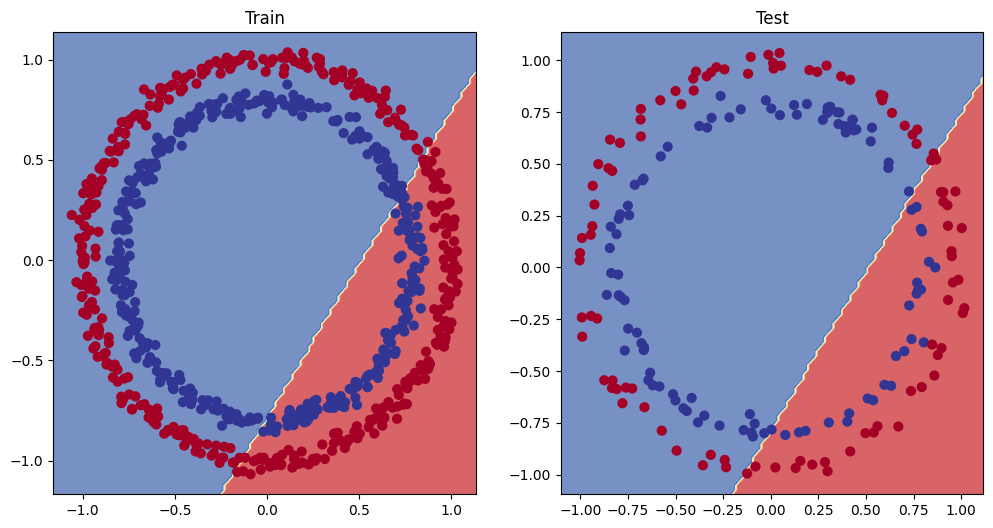

In [24]:
from helper_functions import plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model0, X_test, y_test)

# 5. Improve through experimentation

There are two ways to improve a deep learning model:

* **Feature engineering**: adjusting the inputs to the model (e.g. using a different dataset, scaling, etc.)
* **Hyperparameter tuning**: adjusting the configuration of the model (e.g. number of layers, number of hidden units, learning rate, etc.)
 
From a model's perspective, hyperparameter tuning is the most important. If the model is not learning, it doesn't matter how good the features are. However, if the model is learning, it can be improved by better features. Some common hyperparameters to tune are:

* Add more layers: give the model more chances to learn complex relationships between features and labels
* Add more neurons: each layer will have more parameters to learn from (but don't go too high or the model will overfit)
* Train for longer: give the model more chances to learn the patterns in the data (but don't go too long or the model will overfit)
* Change the activation function: can help the model learn in different fashion (e.g. ReLU vs. Tanh)
* Change the learning rate: can speed up training if the model is learning slowly (but don't go too high or the weights will explode)
* Change the loss function: can help model learn faster (e.g. BCEWithLogitsLoss vs. MSE)
* Change the optimizer: can help model learn faster (e.g. Adam vs. SGD)

## 5.1. Experiment adding extra layers and neurons and trainer for longer

In [25]:
model1 = nn.Sequential(
  nn.Linear(in_features=2, out_features=256),
  nn.Linear(in_features=256, out_features=128),
  nn.Linear(in_features=128, out_features=64),
  nn.Linear(in_features=64, out_features=32),
  nn.Linear(in_features=32, out_features=16),
  nn.Linear(in_features=16, out_features=8),
  nn.Linear(in_features=8, out_features=4),
  nn.Linear(in_features=4, out_features=2),
  nn.Linear(in_features=2, out_features=1)
).to(device)

loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.SGD(params=model1.parameters(), lr=0.1)

model1.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=256, bias=True)
  (1): Linear(in_features=256, out_features=128, bias=True)
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): Linear(in_features=32, out_features=16, bias=True)
  (5): Linear(in_features=16, out_features=8, bias=True)
  (6): Linear(in_features=8, out_features=4, bias=True)
  (7): Linear(in_features=4, out_features=2, bias=True)
  (8): Linear(in_features=2, out_features=1, bias=True)
)

In [26]:
train_eval_loop(
  model=model1, 
  loss_fn=loss_fn, 
  optim=optim, 
  X_train=X_train, 
  y_train=y_train, 
  X_test=X_test, 
  y_test=y_test,
  epochs=1001,
  verbose_every=100
)

epoch: 0, loss: 0.72, accuracy: 0.50%, f1: 0.33
epoch: 100, loss: 0.69, accuracy: 0.50%, f1: 0.33
epoch: 200, loss: 0.69, accuracy: 0.50%, f1: 0.33
epoch: 300, loss: 0.69, accuracy: 0.46%, f1: 0.45
epoch: 400, loss: 0.69, accuracy: 0.48%, f1: 0.48
epoch: 500, loss: 0.69, accuracy: 0.47%, f1: 0.47
epoch: 600, loss: 0.69, accuracy: 0.46%, f1: 0.46
epoch: 700, loss: 0.69, accuracy: 0.47%, f1: 0.47
epoch: 800, loss: 0.69, accuracy: 0.47%, f1: 0.46
epoch: 900, loss: 0.69, accuracy: 0.47%, f1: 0.47
epoch: 1000, loss: 0.69, accuracy: 0.47%, f1: 0.47


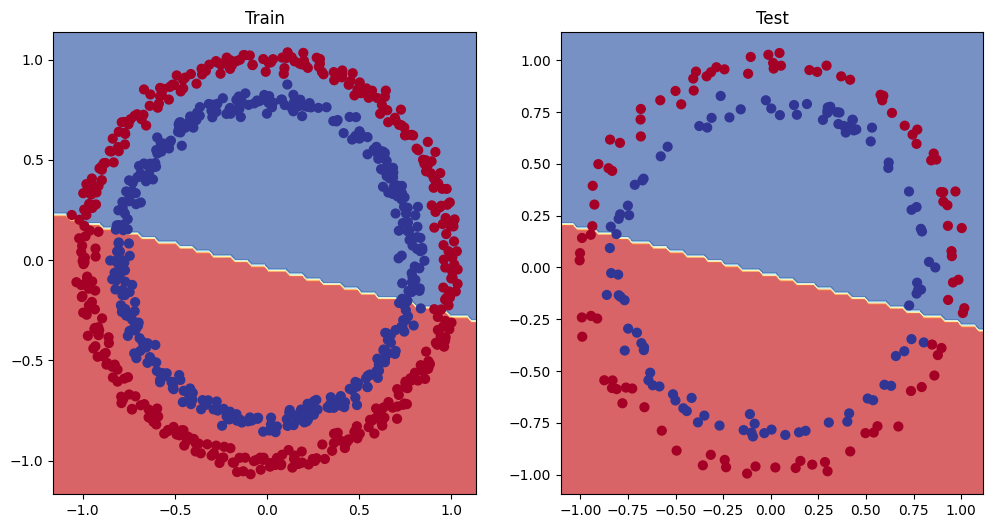

In [27]:
from helper_functions import plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model1, X_test, y_test)

## 5.2. Experiment training on a linear dataset

One way to troubleshot a model is to feed it a linear dataset (e.g. `y = 2x + 1`) and see if it learns the correct relationship between `x` and `y`. If it doesn't, it means there's a bug somewhere in the training loop.

In [41]:
X_linear = torch.arange(start=0, end=1, step=0.01).to(device)
X_linear = X_linear.reshape(50, 2)
X_linear.shape

torch.Size([50, 2])

In [42]:
weight = 0.7
bias = 0.3

y_linear = (bias + weight * X_linear[:, 0] * X_linear[:, 1]).to(device)
y_linear.shape

torch.Size([50])

In [43]:
from sklearn.model_selection import train_test_split

X_linear_train, X_linear_test, y_linear_train, y_linear_test = train_test_split(X_linear, y_linear, test_size=0.2, random_state=42, shuffle=True)
X_linear_train.shape, X_linear_test.shape, y_linear_train.shape, y_linear_test.shape

(torch.Size([40, 2]), torch.Size([10, 2]), torch.Size([40]), torch.Size([10]))

In [46]:
train_eval_loop(
  model=model1, 
  loss_fn=loss_fn, 
  optim=optim, 
  X_train=X_linear_train, 
  y_train=y_linear_train, 
  X_test=X_linear_test, 
  y_test=y_linear_test
)

ValueError: Target size (torch.Size([40, 1, 1])) must be the same as input size (torch.Size([40]))

# 6. Save and reload the trained model

# References:

1. [Batch 32 - Yann LeCun @ Twitter](https://twitter.com/ylecun/status/989610208497360896)
2. [Ground truth notebook](https://www.learnpytorch.io/02_pytorch_classification/)